In [ ]:
!pip install torch torchvision torchaudio

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn

In [2]:
source_csv = 'dataframe_brown_bread_normalized.csv'
df = pd.read_csv(source_csv)
# 1. Preprocessing
# Combine the one-hot encoded columns into a single categorical feature
# Drop the original one-hot columns
# Assuming your DataFrame is named `df`
df = df.dropna()
# Optionally, you can reset the index after dropping rows
df.reset_index(drop=True, inplace=True)
df['fun_bit_category'] = df[['fun_bit_1', 'fun_bit_2',
                             'fun_bit_3', 'fun_bit_4']].idxmax(axis=1)
df['fun_bit_category'] = df['fun_bit_category'].map(
    {'fun_bit_1': 0.25, 'fun_bit_2': 0.50, 'fun_bit_3': 0.75, 'fun_bit_4': 1})

# Drop the original one-hot columns
df = df.drop(columns=['fun_bit_1', 'fun_bit_2', 'fun_bit_3', 'fun_bit_4'])
print(df)

    acrylamide_density   avg_t_0   avg_t_1   avg_t_2   avg_t_3   avg_t_4  \
0             0.348343  0.442662  0.327158  0.286723  0.273643  0.264805   
1             0.463123  0.524485  0.313620  0.296473  0.268143  0.256519   
2             0.399265  0.522235  0.344080  0.300709  0.276097  0.258302   
3             0.398652  0.232659  0.236360  0.237007  0.227781  0.233614   
4             0.357438  0.687300  0.369728  0.320491  0.302338  0.283724   
5             0.399284  0.657615  0.354536  0.328291  0.298714  0.293315   
6             0.411518  0.742525  0.402236  0.335901  0.228291  0.228332   
7             0.476155  0.229734  0.230253  0.230113  0.227062  0.227485   
8             0.398412  0.615739  0.387089  0.327127  0.294689  0.283356   
9             0.436468  0.828115  0.436568  0.352882  0.309156  0.288372   
10            0.496663  0.231829  0.226382  0.232337  0.234322  0.232453   
11            0.513796  0.229965  0.227535  0.227025  0.231807  0.226461   
12          

**RADOM FOREST MODEL**

Mean Squared Error: 0.0013945251669931808
R-squared: 0.9343925873033871


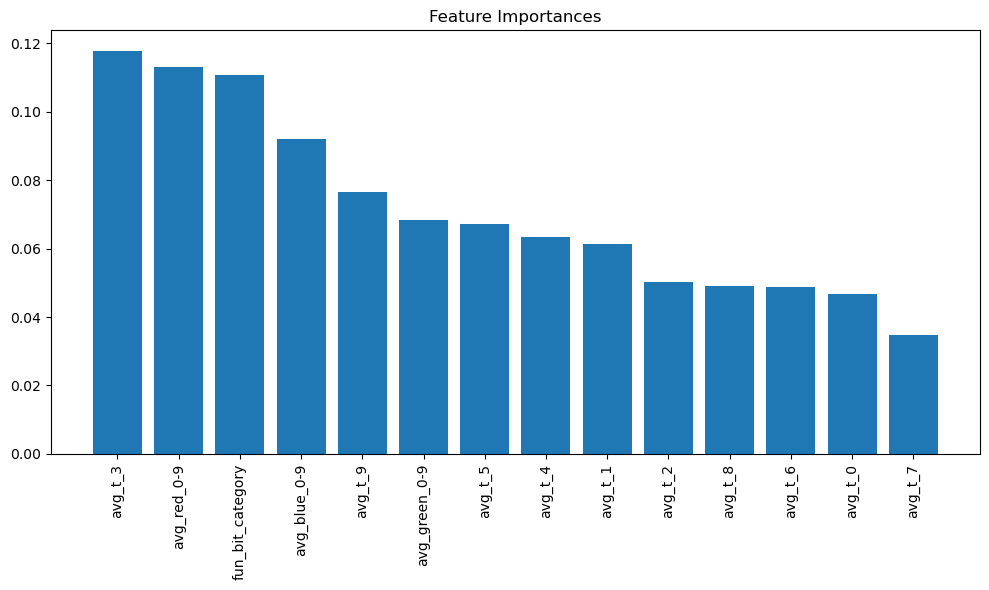

In [6]:
# Separate features and target variable
X = df.drop(columns=['acrylamide_density'])
y = df['acrylamide_density']

# 2. Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 3. Model training
# Using RandomForestRegressor as an example
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Predictions and Evaluation
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optionally, plot feature importance if using Random Forest
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importance[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

**LSTM MODEL**

In [4]:
# Separate features and target variable and Convert to numpy arrays
X_temp = df[['avg_t_0', 'avg_t_1', 'avg_t_2', 'avg_t_3', 'avg_t_4',
             'avg_t_5', 'avg_t_6', 'avg_t_7', 'avg_t_8', 'avg_t_9']].to_numpy()
X_other = df[['fun_bit_category', 'avg_red_0-9',
              'avg_green_0-9', 'avg_blue_0-9']].to_numpy()
y = df['acrylamide_density']

# Reshape to (samples, time steps, features)
X_temp = X_temp.reshape(-1, 10, 1)

# Split the data into training and testing sets
X_temp_train, X_temp_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_temp, X_other, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_temp_train_tensor = torch.tensor(X_temp_train, dtype=torch.float32)
X_temp_test_tensor = torch.tensor(X_temp_test, dtype=torch.float32)
X_other_train_tensor = torch.tensor(X_other_train, dtype=torch.float32)
X_other_test_tensor = torch.tensor(X_other_test, dtype=torch.float32)
# Reshape for compatibility
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the LSTM model


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, other_input_size):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Combining LSTM output and other features
        self.fc1 = nn.Linear(hidden_size + other_input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x_temp, x_other):
        lstm_out, _ = self.lstm(x_temp)
        # Take the output from the last time step
        lstm_out_last = lstm_out[:, -1, :]
        # Concatenate with other features
        combined = torch.cat((lstm_out_last, x_other), dim=1)
        out = self.fc1(combined)
        out = self.fc2(out)
        return out


# Hyperparameters
input_size = 1  # Number of features for temperature
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting a single value
other_input_size = X_other.shape[1]  # Number of additional features
num_epochs = 100  # Number of epochs
learning_rate = 0.001  # Learning rate

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, other_input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_temp_train_tensor, X_other_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_temp_test_tensor, X_other_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Optionally, convert predictions back to numpy for further analysis
y_pred = y_pred_tensor.numpy()
y_test = y_test_tensor.numpy()
print(f'y_pred == {y_pred}')
print(f'y_test == {y_test}')

Epoch [10/100], Loss: 0.0929
Epoch [20/100], Loss: 0.0492
Epoch [30/100], Loss: 0.0259
Epoch [40/100], Loss: 0.0248
Epoch [50/100], Loss: 0.0218
Epoch [60/100], Loss: 0.0195
Epoch [70/100], Loss: 0.0179
Epoch [80/100], Loss: 0.0163
Epoch [90/100], Loss: 0.0149
Epoch [100/100], Loss: 0.0137
Test Loss: 0.0047
y_pred == [[0.39859816]
 [0.38624024]
 [0.46290994]
 [0.6470825 ]]
y_test == [[0.3483425 ]
 [0.46312332]
 [0.399284  ]
 [0.72691464]]


In [5]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

Mean Absolute Error (MAE): 0.0676
Mean Squared Error (MSE): 0.0047
Root Mean Squared Error (RMSE): 0.0687
R-squared: 0.7782
